In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

from sklearn.metrics import recall_score, f1_score, roc_auc_score

# Some auxiliary functions for scoring and tuning
import scoring_utils, tuning_utils

#DEV
import importlib as imp
np.random.seed(33)


In [2]:
# Import the dataframe cleaned during the feature importance process.
df = pd.read_csv('data_for_trees.csv')
target = 'Default'

In [3]:
df

,Term,InterestRate,SBARatio,BankLoans,UrbanRural_0,RetainedJob,RevLineCr,DisbursementGross,SBA_Appv,Default
0,84,5.19,0.80,5045.0,True,0,0,60000.0,48000.0,0
1,60,5.19,0.80,757.0,True,0,0,40000.0,32000.0,0
2,180,5.19,0.75,6.0,True,0,0,287000.0,215250.0,0
3,60,5.19,0.80,54.0,True,0,0,35000.0,28000.0,0
4,240,5.19,1.00,1769.0,True,7,0,229000.0,229000.0,0
...,...,...,...,...,...,...,...,...,...,...
870509,60,5.19,0.80,47508.0,True,0,0,70000.0,56000.0,0
870510,60,5.19,0.50,47508.0,True,0,1,85000.0,42500.0,0
870511,108,5.19,0.75,1294.0,True,0,0,300000.0,225000.0,0
870512,60,5.19,0.80,1105.0,True,0,0,75000.0,60000.0,1


In [4]:
features = [f for f in df.columns if f not in target]

In [16]:
X_total = df[features]
y_total = df[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, train_size=.9)


In [17]:
import xgboost as xgb

best_model = xgb.XGBClassifier()
best_model.load_model('best_tree.json')

In [18]:
best_cutoff = tuning_utils.get_cutoff(best_model, X_total, y_total)

Cutoff: 0.4 , Profit: $7,167,294,700.00
Cutoff: 0.45 , Profit: $7,186,558,577.25
Cutoff: 0.5 , Profit: $7,193,562,322.05
Cutoff: 0.525 , Profit: $7,188,044,263.45
Cutoff: 0.55 , Profit: $7,176,882,333.85
Cutoff: 0.575 , Profit: $7,162,657,965.55
Cutoff: 0.6 , Profit: $7,146,762,804.40


In [19]:
print(f"We will accept loans that score less than {best_cutoff} in our model.")

We will accept loans that score less than 0.5 in our model.


In [20]:
yhat_total = best_model.predict_proba(X_total)[:,1]
yhat_test = best_model.predict_proba(X_test)[:,1]
pd.concat([
    scoring_utils.get_metrics_and_profit(X_total, y_total, yhat_total>best_cutoff, "Best Model Total"),
    scoring_utils.get_metrics_and_profit(X_test, y_test, yhat_test>best_cutoff, "Best Model Test")
])


,Recall,Precision,ROC,F1,"Profit, $"
Best Model Total,0.928849,0.823537,0.943831,0.873029,"7,193,562,322.05"
Best Model Test,0.928614,0.821622,0.943222,0.871848,"712,394,898.50"


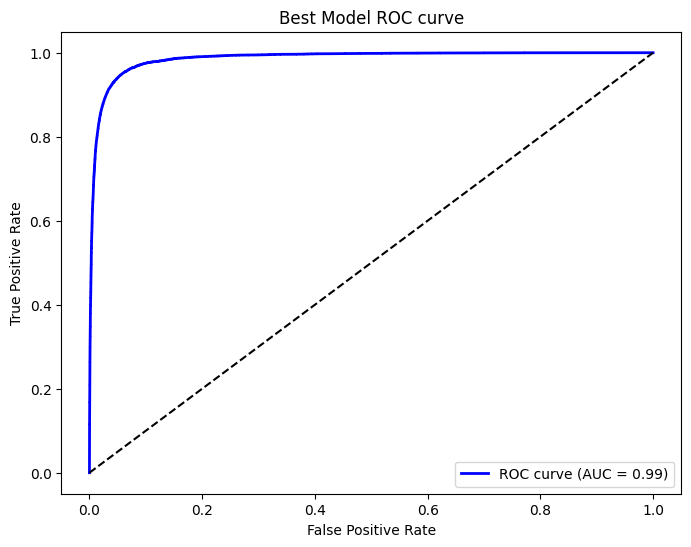

In [21]:
scoring_utils.get_roc_plot(y_test, yhat_test, "Best Model")

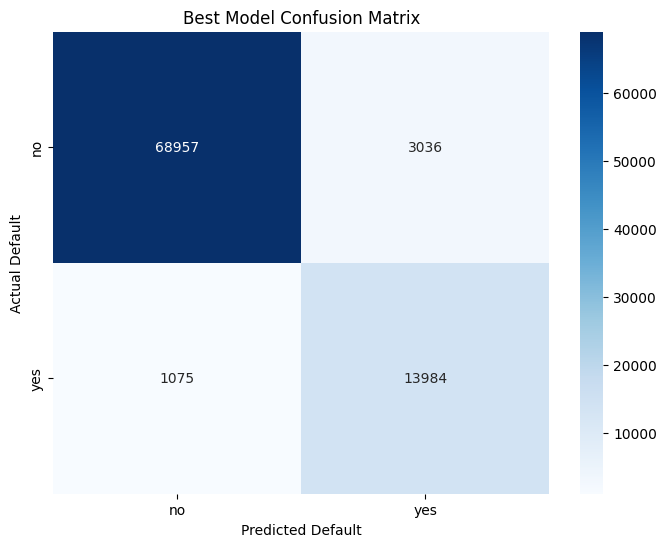

In [22]:
scoring_utils.get_confusion_matrix(y_test, yhat_test>best_cutoff, "Best Model")

In [29]:
predictions_df = pd.DataFrame(yhat_total, columns=['DefaultProbability'])
y_total_df = pd.DataFrame(y_total)

predictions_test_df = pd.DataFrame(yhat_test, columns=['DefaultProbability'])
y_test_df = pd.DataFrame(y_test)

# Joining the DataFrames
result = pd.concat([
    X_total,
    y_total_df,
    predictions_df
], axis=1)

result_test = pd.concat([
    X_test,
    y_test_df,
    predictions_test_df
], axis=1)

result = result.sort_values(by='DefaultProbability')
result_test = result_test.sort_values(by='DefaultProbability')

With out model, we should accept 80.38% percent of the loans, or the 699722 least risky loans, generating a profit of $7,194,213,736.60.


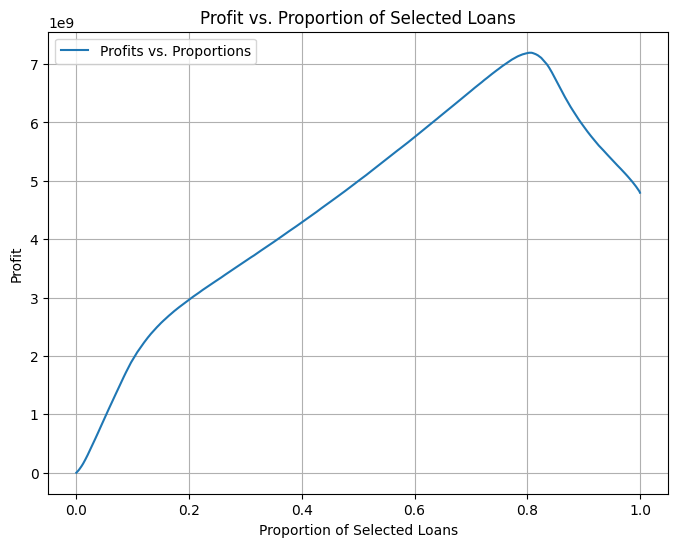

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of proportions to try
num_proportions = 1000  # Choose the number of proportions to try
prop_selected_loans_list = np.linspace(0, 1, num=num_proportions)

# Initialize arrays to store profits and selected proportions
profits = []
selected_proportions = []

best_loans_prop = 0
best_profit = 0

for prop_selected_loans in prop_selected_loans_list:
    n_accepted_loans = int(len(result) * prop_selected_loans)
    accepted_loans = result.head(n_accepted_loans)

    profit = scoring_utils.get_profit(
        accepted_loans, accepted_loans['Default'], np.zeros(n_accepted_loans)
    )

    profits.append(profit)
    selected_proportions.append(prop_selected_loans)

    if profit > best_profit:
        best_profit = profit
        best_loans_prop = prop_selected_loans

print(f"With out model, we should accept {best_loans_prop*100:.2f}% percent of the loans, or the {int(best_loans_prop*len(result))} least risky loans, generating a profit of ${best_profit:,.2f}.")

# Plotting the profits for each proportion
plt.figure(figsize=(8, 6))
plt.plot(selected_proportions, profits, label='Profits vs. Proportions')
plt.xlabel('Proportion of Selected Loans')
plt.ylabel('Profit')
plt.title('Profit vs. Proportion of Selected Loans')
plt.legend()
plt.grid(True)
plt.show()
